In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class UNet(nn.Module):
    """
    Extended U-Net that can optionally accept a conditioning tensor.

    Args:
        in_channels (int): number of channels for the main input (e.g., 2 for real+imag).
        out_channels (int): output channels (e.g., 2 for real+imag).
        cond_channels (int): additional channels for conditioning.
        features (list): number of feature maps in each encoder layer.
        partial_skip (bool): if True, skip the final skip connection.
    """
    def __init__(
        self,
        in_channels=2,
        out_channels=2,
        cond_channels=0,
        features=[64, 128, 256],
        partial_skip=False
    ):
        super(UNet, self).__init__()
        self.partial_skip = partial_skip
        total_in = in_channels + cond_channels

        # Encoder blocks.
        self.encoders = nn.ModuleList()
        prev_channels = total_in
        for feature in features:
            self.encoders.append(self._block(prev_channels, feature))
            prev_channels = feature

        # Bottleneck: keep same channel count as the last encoder.
        self.bottleneck = self._block(features[-1], features[-1])

        # Decoder blocks.
        # We design three decoder blocks:
        # - Block 0: input 256, output 256.
        # - Block 1: input 256, output 128.
        # - Block 2: input 128, output 64.
        self.decoders = nn.ModuleList([
            self._block(features[-1], features[-1]),  # Block 0: 256 -> 256.
            self._block(features[-1], features[-2]),  # Block 1: 256 -> 128.
            self._block(features[-2], features[0])     # Block 2: 128 -> 64.
        ])

        # Projection layers to match skip connections:
        # For decoder block 1, project skip2 (128 channels) to 256.
        self.proj_skip2 = nn.Conv2d(features[1], features[-1], kernel_size=1)  # 128 -> 256.
        # For decoder block 2, project skip1 (64 channels) to 128.
        self.proj_skip1 = nn.Conv2d(features[0], features[-2], kernel_size=1)   # 64 -> 128.

        # Final output layer.
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)  # from 64 to out_channels.

    def _block(self, in_channels, out_channels):
        """A simple block with two convolutional layers and ReLU activations."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t=None, cond=None):
        """
        Forward pass with optional conditioning.
        If `cond` is provided, it should have shape [B, cond_channels, H, W].
        """
        # 1) Concatenate conditioning if provided.
        if cond is not None:
            x = torch.cat([x, cond], dim=1)

        # 2) Encoder pathway.
        skips = []
        for encode in self.encoders:
            x = encode(x)
            skips.append(x)

        # 3) Bottleneck.
        x = self.bottleneck(x)

        # 4) Decoder with skip connections.
        # Assume there are three skip connections: skip1 (64), skip2 (128), skip3 (256).
        num_skips = len(skips)  # should be 3.
        num_skips_to_use = num_skips if not self.partial_skip else num_skips - 1

        for i, decode in enumerate(self.decoders):
            if i < num_skips_to_use:
                skip = skips[-(i+1)]
                if i == 1:
                    # For decoder block 1, project skip2 from 128 to 256.
                    skip = self.proj_skip2(skip)
                if i == 2:
                    # For decoder block 2, project skip1 from 64 to 128.
                    skip = self.proj_skip1(skip)
                x = x + skip
            x = decode(x)
        return self.final(x)

In [ ]:
class DDIM(nn.Module):
    def __init__(
        self,
        unet,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        schedule="linear",
        device='cpu'
    ):
        super(DDIM, self).__init__()
        self.unet = unet.to(device)
        self.timesteps = timesteps
        self.device = device


        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        elif schedule == "cosine":
            self.betas = self._cosine_beta_schedule(timesteps).to(device)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]]
        )

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def _cosine_beta_schedule(self, timesteps, warmup_frac=0.02):
        """
        warmup_frac: Fraction of timesteps used as a 'warmup'
                    where betas grow very slowly from near-zero.
        """
        # Convert fraction to actual number of warmup steps
        warmup_steps = int(timesteps * warmup_frac)

        steps = torch.arange(timesteps + 1, dtype=torch.float64, device=self.device)

        # Tiny offset (s) for better numerical stability near t=0:
        s = 0.008

        # Compute the full cosine alphas_cumprod as before
        alphas_cumprod_full = torch.cos(((steps / timesteps) + s) / (1 + s) * (torch.pi / 2))**2
        alphas_cumprod_full = alphas_cumprod_full / alphas_cumprod_full[0]  # Normalize so alpha(0)=1

        # override the first 'warmup_steps' portio nwith a near-linear ramp from 1 down to whatever the original curve
        # keeps betas extremely small initially.
        if warmup_steps > 0:
            # The alpha at the end of warmup
            alpha_end_warmup = alphas_cumprod_full[warmup_steps]

            warmup_range = torch.linspace(1.0, alpha_end_warmup, warmup_steps + 1, device=self.device)
            alphas_cumprod_full[: warmup_steps + 1] = warmup_range

        # Convert alphas to betas (1 - alpha_{t} / alpha_{t-1})
        betas = 1 - (alphas_cumprod_full[1:] / alphas_cumprod_full[:-1])
        return betas.float()


    def forward_diffusion(self, x_start, t):
        """
        q(x_t | x_0): Diffuse x_start to x_t at time t by adding noise.
        """
        noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x_t = sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
        return x_t, noise
    
    def forward(self, x, t, cond=None):
        """
        Forward method for training. Predicts the noise from the input x at timestep t.
        If conditioning is provided, it passes it along to the U-Net.
        """
        return self.unet(x, t, cond=cond)

    def enforce_data_consistency(self, x_pred, x_measured, mask):
        """
        Simplified example of data consistency in the image domain:
        merges predicted image and measured image using a binary mask.

        For typical undersampled MRI, you'd often do:
          1) FFT x_pred  -> kspace_pred
          2) Replace known lines in kspace_pred with x_measured (which is k-space)
          3) iFFT -> new x_pred
        This is just a placeholder approach.
        """
        # Fix the logic: real "mask" in image domain might be 1 for known, 0 for unknown
        # Combine: known region from x_measured, unknown from x_pred
        # Make sure shapes are broadcast-compatible
        return x_pred * (1 - mask) + x_measured * mask

    def reverse_diffusion(self, x_t, t, x_measured=None, mask=None, eta=0):
        """
        p(x_{t-1} | x_t): reverse step, plus optional data consistency enforcement.

        Args:
          x_t: shape [B, C, H, W] (image domain) or possibly different dims if coil
          t: shape [B], the current time steps
          x_measured: optional, same shape as x_t or fewer channels if we do mask merges
          mask: optional, binary or float mask
          eta: additional noise parameter for DDIM sampling
        """
        cond = None
        if x_measured is not None and mask is not None:
            # Example: cat measured & mask along channel dim
            cond = torch.cat([x_measured, mask], dim=1)

        # 1) Predict noise with the U-Net
        pred_noise = self.unet(x_t, t, cond=cond)

        # 2) Equations for DDIM step
        alpha = self.alphas[t][:, None, None, None]
        alpha_cumprod = self.alphas_cumprod[t][:, None, None, None]
        alpha_cumprod_prev = self.alphas_cumprod_prev[t][:, None, None, None]

        pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod) * pred_noise) / torch.sqrt(alpha_cumprod)
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        pred_mean = torch.sqrt(alpha_cumprod_prev) * pred_x0 + \
                    torch.sqrt(1 - alpha_cumprod_prev) * pred_noise

        # 3) Add optional stochasticity
        if eta > 0:
            noise = torch.randn_like(x_t)
            sigma = eta * torch.sqrt(self.posterior_variance[t])[:, None, None, None]
            pred_mean = pred_mean + sigma * noise

        # 4) Data consistency
        if (x_measured is not None) and (mask is not None):
            pred_mean = self.enforce_data_consistency(
                x_pred=pred_mean, x_measured=x_measured, mask=mask
            )

        return pred_mean

    def sample(self, shape, x_measured=None, mask=None, eta=0):
        """
        Generate samples using DDIM sampling. We assume x_measured, mask
        are the same shape or broadcastable with x_t.

        If x_measured is in k-space, you'd need a different DC approach.
        """
        x_t = torch.randn(shape, device=self.device)

        for timestep in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), timestep, device=self.device, dtype=torch.long)
            x_t = self.reverse_diffusion(
                x_t, t_tensor, x_measured=x_measured, mask=mask, eta=eta
            )

        return x_t

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class MRIDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (str): Path to the folder containing the processed .pt files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder = folder
        self.filenames = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filepath = os.path.join(self.folder, self.filenames[idx])
        sample = torch.load(filepath)
        # If the sample has 4 dimensions, we assume its shape is [kx, ky, complex, coil]
        # and we want to convert it to [C, H, W] with C = complex * coil, H = kx, W = ky.
        if sample.ndim == 4:
            # Permute from [kx, ky, complex, coil] to [complex, coil, kx, ky]
            sample = sample.permute(2, 3, 0, 1)
            # Reshape to combine the complex and coil dimensions
            complex_dim, coil_dim, kx, ky = sample.shape
            sample = sample.reshape(complex_dim * coil_dim, kx, ky)
        if self.transform:
            sample = self.transform(sample)
        return sample

def pad_collate_fn(batch, global_max_channels):
    """
    Pads a list of tensors (each of shape [C, H, W]) along the channel, height, 
    and width dimensions so that each sample is padded (or cropped) to:
      - channels: global_max_channels
      - height: max height in the batch
      - width: max width in the batch
    Returns:
        torch.Tensor: Batched tensor of shape [batch_size, global_max_channels, max_H, max_W]
    """
    # Compute max height and width among samples in this batch.
    max_h = max(sample.shape[1] for sample in batch)
    max_w = max(sample.shape[2] for sample in batch)
    
    padded_batch = []
    for sample in batch:
        c, h, w = sample.shape
        # Pad channels: if sample has fewer than global_max_channels, pad; if more, crop.
        if c < global_max_channels:
            pad_c = global_max_channels - c
            sample = F.pad(sample, (0, 0, 0, 0, 0, pad_c))
        elif c > global_max_channels:
            sample = sample[:global_max_channels, :, :]
        # Pad spatial dimensions
        pad_h = max_h - sample.shape[1]
        pad_w = max_w - sample.shape[2]
        padded_sample = F.pad(sample, (0, pad_w, 0, pad_h))
        padded_batch.append(padded_sample)
    
    return torch.stack(padded_batch)

def compute_global_max_channels(data_folder):
    """
    Computes the maximum channel count across all .pt files in data_folder.
    Assumes each file, when properly transformed, has shape [C, H, W].
    """
    max_channels = 0
    for f in os.listdir(data_folder):
        if f.endswith('.pt'):
            sample = torch.load(os.path.join(data_folder, f))
            # Apply transformation if sample is 4D.
            if sample.ndim == 4:
                sample = sample.permute(2, 3, 0, 1).reshape(-1, sample.shape[0], sample.shape[1])
            max_channels = max(max_channels, sample.shape[0])
    return max_channels

def get_mri_dataloader(data_folder, batch_size=8, shuffle=True, num_workers=0):
    """
    Creates a DataLoader for the processed MRI data.
    
    Args:
        data_folder (str): Path to the folder containing processed .pt files.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the dataset.
        num_workers (int): Number of worker processes for data loading.
    
    Returns:
        DataLoader: A PyTorch DataLoader ready to be passed to your model.
    """
    dataset = MRIDataset(data_folder)
    global_max_channels = compute_global_max_channels(data_folder)
    # Wrap the collate function to automatically pass global_max_channels.
    collate_fn = lambda batch: pad_collate_fn(batch, global_max_channels)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            collate_fn=collate_fn)
    return dataloader


In [ ]:
from tqdm import tqdm 
import torch.optim as optim
from torch.utils.data import DataLoader

def train_diffusion_model(
    data_folder,
    num_epochs=10,
    lr=1e-4,
    timesteps=1000,
    batch_size=2,
    schedule="linear",
    beta_start=1e-4,
    beta_end=0.02,
    cond_channels=0,
    partial_skip=False,
    device=None,
    checkpoint_dir=None,
    final_model_path=None
):
    """
    Train a diffusion model (DDIM + improved U-Net) on processed MRI data.
    Data is assumed to be .pt files of shape [C, H, W].

    Args:
        data_folder (str): Path to folder containing .pt files (e.g. [coil*2, H, W]).
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate for optimizer.
        timesteps (int): Number of diffusion steps (beta schedule length).
        batch_size (int): Dataloader batch size.
        schedule (str): "linear" or "cosine".
        beta_start (float): Start of beta range for diffusion schedule.
        beta_end (float): End of beta range.
        cond_channels (int): If > 0, the U-Net can accept additional conditioning channels.
        partial_skip (bool): Whether to skip the final skip connection in the U-Net.
        device (torch.device): If None, will auto-detect CUDA.
        checkpoint_dir (str): Directory to save model checkpoints. If None, checkpoints are not saved.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # checkpoint directory
    if checkpoint_dir is not None:
        os.makedirs(checkpoint_dir, exist_ok=True)

    dataset = MRIDataset(data_folder)
    global_max_channels = compute_global_max_channels(data_folder)

    def collate_fn(batch):
        return pad_collate_fn(batch, global_max_channels)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
    )

    sample = dataset[0]  # expected shape: [C, H, W]
    in_channels = sample.shape[0]
    print(f"Detected in_channels: {in_channels}")
    print("Sample shape:", sample.shape)

    #  improved U-Net
    unet = UNet(
        in_channels=global_max_channels,    # input channels (max channels across dataset)
        out_channels=global_max_channels,   # output channels
        cond_channels=cond_channels,        # optional conditioning channels
        features=[64, 128, 256],            # can be adjusted as needed
        partial_skip=partial_skip
    ).to(device)

    #  DDIM
    ddim = DDIM(
        unet=unet,
        timesteps=timesteps,
        beta_start=beta_start,
        beta_end=beta_end,
        schedule=schedule,
        device=device
    )

    #  loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ddim.parameters(), lr=lr)

    # raining loop
    for epoch in range(num_epochs):
        ddim.train()
        epoch_loss = 0.0

        # tqdm for a progress bar over the dataloader
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = batch.to(device)  # batch shape: (B, C, H, W)

            # Sample random timesteps for each batch element
            t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()

            # Forward diffusion: get the noised version and the applied noise
            x_t, noise = ddim.forward_diffusion(batch, t)

            # Optional: build conditioning if available (here, we set it to None)
            cond = None

            # Predict the noise from x_t using the DDIM model (i.e., the improved U-Net)
            pred_noise = ddim(x_t, t, cond=cond)

            # Calculate loss against the ground truth noise
            loss = criterion(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.6f}")

        if checkpoint_dir is not None:
            checkpoint_path = os.path.join(checkpoint_dir, f"ddim_epoch_{epoch+1}.pt")
            torch.save(ddim.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    if final_model_path is not None:
      torch.save(ddim.state_dict(), final_model_path)
      print(f"Final model saved at: {final_model_path}")

    print("Training complete!")
    return ddim  # Return the trained diffusion model

In [84]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/1_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder=data_folder,
        num_epochs=10,
        lr=1e-4,
        timesteps=1000,
        batch_size=2,
        schedule="linear",
        beta_start=1e-4,
        beta_end=0.02,
        cond_channels=0,
        partial_skip=False,
        device=None,               # Will auto-detect GPU if available
        checkpoint_dir=checkpoint_directory,
        final_model_path=final_model_path
    )

Using device: cuda
Detected in_channels: 30
Sample shape: torch.Size([30, 512, 208])


Epoch 1/10: 100%|██████████| 3055/3055 [1:03:24<00:00,  1.25s/it]


Epoch [1/10]  Loss: 0.747562
Saved checkpoint: checkpoints/ddim_epoch_1.pt


Epoch 2/10: 100%|██████████| 3055/3055 [1:06:59<00:00,  1.32s/it]


Epoch [2/10]  Loss: 0.613777
Saved checkpoint: checkpoints/ddim_epoch_2.pt


Epoch 3/10: 100%|██████████| 3055/3055 [1:08:39<00:00,  1.35s/it]


Epoch [3/10]  Loss: 0.560465
Saved checkpoint: checkpoints/ddim_epoch_3.pt


Epoch 4/10: 100%|██████████| 3055/3055 [1:09:11<00:00,  1.36s/it]


Epoch [4/10]  Loss: 0.539275
Saved checkpoint: checkpoints/ddim_epoch_4.pt


Epoch 5/10: 100%|██████████| 3055/3055 [1:09:15<00:00,  1.36s/it]


Epoch [5/10]  Loss: 0.527144
Saved checkpoint: checkpoints/ddim_epoch_5.pt


Epoch 6/10: 100%|██████████| 3055/3055 [1:10:07<00:00,  1.38s/it]


Epoch [6/10]  Loss: 0.515371
Saved checkpoint: checkpoints/ddim_epoch_6.pt


Epoch 7/10: 100%|██████████| 3055/3055 [1:12:03<00:00,  1.42s/it]


Epoch [7/10]  Loss: 0.508166
Saved checkpoint: checkpoints/ddim_epoch_7.pt


Epoch 8/10: 100%|██████████| 3055/3055 [1:09:55<00:00,  1.37s/it]


Epoch [8/10]  Loss: 0.505433
Saved checkpoint: checkpoints/ddim_epoch_8.pt


Epoch 9/10: 100%|██████████| 3055/3055 [1:11:00<00:00,  1.39s/it]


Epoch [9/10]  Loss: 0.508539
Saved checkpoint: checkpoints/ddim_epoch_9.pt


Epoch 10/10: 100%|██████████| 3055/3055 [1:13:45<00:00,  1.45s/it]

Epoch [10/10]  Loss: 0.507014
Saved checkpoint: checkpoints/ddim_epoch_10.pt
Final model saved at: models/1_model.pt
Training complete!


In [85]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/2_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder=data_folder,
        num_epochs=20,
        lr=1e-4,
        timesteps=1000,
        batch_size=4,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        cond_channels=0,
        partial_skip=False,
        device=None,               # Will auto-detect GPU if available
        checkpoint_dir=checkpoint_directory,
        final_model_path=final_model_path
    )

Using device: cuda
Detected in_channels: 30
Sample shape: torch.Size([30, 512, 208])


Epoch 1/20: 100%|██████████| 3055/3055 [1:10:06<00:00,  1.38s/it]


Epoch [1/20]  Loss: 0.770811
Saved checkpoint: checkpoints/ddim_epoch_1.pt


Epoch 2/20: 100%|██████████| 3055/3055 [1:10:44<00:00,  1.39s/it]


Epoch [2/20]  Loss: 0.645914
Saved checkpoint: checkpoints/ddim_epoch_2.pt


IOPub message rate exceeded. 673/3055 [16:19<55:45,  1.40s/it]  
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 6/20: 100%|██████████| 3055/3055 [1:10:27<00:00,  1.38s/it]


Epoch [6/20]  Loss: 0.554564
Saved checkpoint: checkpoints/ddim_epoch_6.pt


Epoch 7/20: 100%|██████████| 3055/3055 [1:10:58<00:00,  1.39s/it]


Epoch [7/20]  Loss: 0.532117
Saved checkpoint: checkpoints/ddim_epoch_7.pt


Epoch 8/20: 100%|██████████| 3055/3055 [1:11:27<00:00,  1.40s/it]


Epoch [8/20]  Loss: 0.515193
Saved checkpoint: checkpoints/ddim_epoch_8.pt


Epoch 9/20: 100%|██████████| 3055/3055 [1:11:37<00:00,  1.41s/it]


Epoch [9/20]  Loss: 0.504090
Saved checkpoint: checkpoints/ddim_epoch_9.pt


Epoch 10/20: 100%|██████████| 3055/3055 [1:11:01<00:00,  1.39s/it]


Epoch [10/20]  Loss: 0.503113
Saved checkpoint: checkpoints/ddim_epoch_10.pt


Epoch 11/20: 100%|██████████| 3055/3055 [1:11:28<00:00,  1.40s/it]


Epoch [11/20]  Loss: 0.510574
Saved checkpoint: checkpoints/ddim_epoch_11.pt


Epoch 12/20: 100%|██████████| 3055/3055 [1:10:42<00:00,  1.39s/it]


Epoch [12/20]  Loss: 0.534209
Saved checkpoint: checkpoints/ddim_epoch_12.pt


Epoch 13/20: 100%|██████████| 3055/3055 [1:10:35<00:00,  1.39s/it]


Epoch [13/20]  Loss: 0.526828
Saved checkpoint: checkpoints/ddim_epoch_13.pt


Epoch 14/20: 100%|██████████| 3055/3055 [1:10:28<00:00,  1.38s/it]


Epoch [14/20]  Loss: 0.522283
Saved checkpoint: checkpoints/ddim_epoch_14.pt


Epoch 15/20: 100%|██████████| 3055/3055 [1:10:22<00:00,  1.38s/it]


Epoch [15/20]  Loss: 0.522597
Saved checkpoint: checkpoints/ddim_epoch_15.pt


Epoch 16/20: 100%|██████████| 3055/3055 [1:10:37<00:00,  1.39s/it]


Epoch [16/20]  Loss: 0.522827
Saved checkpoint: checkpoints/ddim_epoch_16.pt


Epoch 17/20: 100%|██████████| 3055/3055 [1:13:14<00:00,  1.44s/it]


Epoch [17/20]  Loss: 0.525293
Saved checkpoint: checkpoints/ddim_epoch_17.pt


Epoch 18/20: 100%|██████████| 3055/3055 [1:11:03<00:00,  1.40s/it]


Epoch [18/20]  Loss: 0.524842
Saved checkpoint: checkpoints/ddim_epoch_18.pt


Epoch 19/20: 100%|██████████| 3055/3055 [1:10:38<00:00,  1.39s/it]


Epoch [19/20]  Loss: 0.523882
Saved checkpoint: checkpoints/ddim_epoch_19.pt


Epoch 20/20: 100%|██████████| 3055/3055 [1:11:10<00:00,  1.40s/it]

Epoch [20/20]  Loss: 0.522847
Saved checkpoint: checkpoints/ddim_epoch_20.pt
Final model saved at: models/2_model.pt
Training complete!


In [87]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/3_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder=data_folder,
        num_epochs=15,
        lr=1e-4,
        timesteps=2000,
        batch_size=8,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.05,
        cond_channels=0,
        partial_skip=False,
        device=None,               # Will auto-detect GPU if available
        checkpoint_dir=checkpoint_directory,
        final_model_path=final_model_path
    )

Using device: cuda
Detected in_channels: 30
Sample shape: torch.Size([30, 512, 208])


Epoch 1/15: 100%|██████████| 764/764 [1:10:09<00:00,  5.51s/it]


Epoch [1/15]  Loss: 0.871322
Saved checkpoint: checkpoints/ddim_epoch_1.pt


Epoch 2/15: 100%|██████████| 764/764 [1:09:00<00:00,  5.42s/it]


Epoch [2/15]  Loss: 0.750602
Saved checkpoint: checkpoints/ddim_epoch_2.pt


Epoch 3/15: 100%|██████████| 764/764 [1:13:06<00:00,  5.74s/it]


Epoch [3/15]  Loss: 0.694001
Saved checkpoint: checkpoints/ddim_epoch_3.pt


Epoch 4/15: 100%|██████████| 764/764 [1:09:56<00:00,  5.49s/it]


Epoch [4/15]  Loss: 0.657333
Saved checkpoint: checkpoints/ddim_epoch_4.pt


Epoch 5/15: 100%|██████████| 764/764 [1:10:26<00:00,  5.53s/it]


Epoch [5/15]  Loss: 0.629889
Saved checkpoint: checkpoints/ddim_epoch_5.pt


Epoch 6/15: 100%|██████████| 764/764 [1:10:03<00:00,  5.50s/it]


Epoch [6/15]  Loss: 0.621281
Saved checkpoint: checkpoints/ddim_epoch_6.pt


Epoch 7/15: 100%|██████████| 764/764 [1:09:56<00:00,  5.49s/it]


Epoch [7/15]  Loss: 0.601611
Saved checkpoint: checkpoints/ddim_epoch_7.pt


Epoch 8/15: 100%|██████████| 764/764 [1:09:59<00:00,  5.50s/it]


Epoch [8/15]  Loss: 0.609662
Saved checkpoint: checkpoints/ddim_epoch_8.pt


Epoch 9/15: 100%|██████████| 764/764 [1:09:34<00:00,  5.46s/it]


Epoch [9/15]  Loss: 0.575513
Saved checkpoint: checkpoints/ddim_epoch_9.pt


Epoch 10/15: 100%|██████████| 764/764 [1:09:44<00:00,  5.48s/it]


Epoch [10/15]  Loss: 0.560400
Saved checkpoint: checkpoints/ddim_epoch_10.pt


Epoch 11/15: 100%|██████████| 764/764 [1:11:25<00:00,  5.61s/it]


Epoch [11/15]  Loss: 0.555419
Saved checkpoint: checkpoints/ddim_epoch_11.pt


Epoch 12/15: 100%|██████████| 764/764 [1:10:10<00:00,  5.51s/it]


Epoch [12/15]  Loss: 0.548409
Saved checkpoint: checkpoints/ddim_epoch_12.pt


Epoch 13/15: 100%|██████████| 764/764 [1:10:46<00:00,  5.56s/it]


Epoch [13/15]  Loss: 0.541412
Saved checkpoint: checkpoints/ddim_epoch_13.pt


Epoch 14/15: 100%|██████████| 764/764 [1:10:20<00:00,  5.52s/it]


Epoch [14/15]  Loss: 0.538123
Saved checkpoint: checkpoints/ddim_epoch_14.pt


Epoch 15/15: 100%|██████████| 764/764 [1:10:34<00:00,  5.54s/it]

Epoch [15/15]  Loss: 0.533196
Saved checkpoint: checkpoints/ddim_epoch_15.pt
Final model saved at: models/3_model.pt
Training complete!


In [91]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/4_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder=data_folder,
        num_epochs=20,
        lr=1e-3,
        timesteps=2000,
        batch_size=2,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        cond_channels=0,
        partial_skip=True,
        device=None,               # Will auto-detect GPU if available
        checkpoint_dir=checkpoint_directory,
        final_model_path=final_model_path
    )

Using device: cuda
Detected in_channels: 30
Sample shape: torch.Size([30, 512, 208])


Epoch 1/20: 100%|██████████| 3055/3055 [1:15:35<00:00,  1.48s/it]  


Epoch [1/20]  Loss: 0.957710
Saved checkpoint: checkpoints/ddim_epoch_1.pt


Epoch 2/20: 100%|██████████| 3055/3055 [1:13:37<00:00,  1.45s/it]


Epoch [2/20]  Loss: 0.923532
Saved checkpoint: checkpoints/ddim_epoch_2.pt


Epoch 3/20: 100%|██████████| 3055/3055 [1:11:42<00:00,  1.41s/it]


Epoch [3/20]  Loss: 0.911774
Saved checkpoint: checkpoints/ddim_epoch_3.pt


Epoch 4/20: 100%|██████████| 3055/3055 [1:11:18<00:00,  1.40s/it]


Epoch [4/20]  Loss: 0.910157
Saved checkpoint: checkpoints/ddim_epoch_4.pt


Epoch 5/20: 100%|██████████| 3055/3055 [1:11:56<00:00,  1.41s/it]


Epoch [5/20]  Loss: 0.908508
Saved checkpoint: checkpoints/ddim_epoch_5.pt


Epoch 6/20: 100%|██████████| 3055/3055 [1:11:20<00:00,  1.40s/it]


Epoch [6/20]  Loss: 0.907562
Saved checkpoint: checkpoints/ddim_epoch_6.pt


Epoch 7/20: 100%|██████████| 3055/3055 [1:11:52<00:00,  1.41s/it]


Epoch [7/20]  Loss: 0.906750
Saved checkpoint: checkpoints/ddim_epoch_7.pt


Epoch 8/20: 100%|██████████| 3055/3055 [1:11:34<00:00,  1.41s/it]


Epoch [8/20]  Loss: 0.906126
Saved checkpoint: checkpoints/ddim_epoch_8.pt


Epoch 9/20: 100%|██████████| 3055/3055 [1:11:59<00:00,  1.41s/it]


Epoch [9/20]  Loss: 0.905788
Saved checkpoint: checkpoints/ddim_epoch_9.pt


Epoch 10/20: 100%|██████████| 3055/3055 [1:11:50<00:00,  1.41s/it]


Epoch [10/20]  Loss: 0.905434
Saved checkpoint: checkpoints/ddim_epoch_10.pt


Epoch 11/20: 100%|██████████| 3055/3055 [1:12:05<00:00,  1.42s/it]


Epoch [11/20]  Loss: 0.905037
Saved checkpoint: checkpoints/ddim_epoch_11.pt


Epoch 12/20: 100%|██████████| 3055/3055 [1:11:41<00:00,  1.41s/it]


Epoch [12/20]  Loss: 0.904704
Saved checkpoint: checkpoints/ddim_epoch_12.pt


Epoch 13/20: 100%|██████████| 3055/3055 [1:12:25<00:00,  1.42s/it]


Epoch [13/20]  Loss: 0.904558
Saved checkpoint: checkpoints/ddim_epoch_13.pt


IOPub message rate exceeded.| 1921/3055 [45:13<31:08,  1.65s/it]  
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 15/20: 100%|██████████| 3055/3055 [1:12:06<00:00,  1.42s/it]


Epoch [15/20]  Loss: 0.904044
Saved checkpoint: checkpoints/ddim_epoch_15.pt


Epoch 16/20: 100%|██████████| 3055/3055 [1:12:16<00:00,  1.42s/it]


Epoch [16/20]  Loss: 0.903749
Saved checkpoint: checkpoints/ddim_epoch_16.pt


Epoch 17/20: 100%|██████████| 3055/3055 [1:11:29<00:00,  1.40s/it]


Epoch [17/20]  Loss: 0.903602
Saved checkpoint: checkpoints/ddim_epoch_17.pt


Epoch 18/20: 100%|██████████| 3055/3055 [1:12:03<00:00,  1.42s/it]


Epoch [18/20]  Loss: 0.903497
Saved checkpoint: checkpoints/ddim_epoch_18.pt


Epoch 19/20: 100%|██████████| 3055/3055 [1:11:34<00:00,  1.41s/it]


Epoch [19/20]  Loss: 0.903306
Saved checkpoint: checkpoints/ddim_epoch_19.pt


Epoch 20/20: 100%|██████████| 3055/3055 [1:11:40<00:00,  1.41s/it]

Epoch [20/20]  Loss: 0.903343
Saved checkpoint: checkpoints/ddim_epoch_20.pt
Final model saved at: models/4_model.pt
Training complete!


In [95]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/5_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder=data_folder,
        num_epochs=30,
        lr=1e-4,
        timesteps=2000,
        batch_size=2,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.03,
        cond_channels=0,
        partial_skip=False,
        device=None,               # Will auto-detect GPU if available
        checkpoint_dir=checkpoint_directory,
        final_model_path=final_model_path
    )

Using device: cuda
Detected in_channels: 30
Sample shape: torch.Size([30, 512, 208])


Epoch 1/30: 100%|██████████| 3055/3055 [1:00:19<00:00,  1.18s/it]


Epoch [1/30]  Loss: 0.776185
Saved checkpoint: checkpoints/ddim_epoch_1.pt


Epoch 2/30: 100%|██████████| 3055/3055 [1:00:15<00:00,  1.18s/it]


Epoch [2/30]  Loss: 0.647565
Saved checkpoint: checkpoints/ddim_epoch_2.pt


Epoch 3/30: 100%|██████████| 3055/3055 [1:00:29<00:00,  1.19s/it]


Epoch [3/30]  Loss: 0.606750
Saved checkpoint: checkpoints/ddim_epoch_3.pt


Epoch 4/30: 100%|██████████| 3055/3055 [1:00:13<00:00,  1.18s/it]


Epoch [4/30]  Loss: 0.602419
Saved checkpoint: checkpoints/ddim_epoch_4.pt


Epoch 5/30: 100%|██████████| 3055/3055 [1:00:02<00:00,  1.18s/it]


Epoch [5/30]  Loss: 0.579372
Saved checkpoint: checkpoints/ddim_epoch_5.pt


Epoch 6/30: 100%|██████████| 3055/3055 [1:00:14<00:00,  1.18s/it]


Epoch [6/30]  Loss: 0.557413
Saved checkpoint: checkpoints/ddim_epoch_6.pt


Epoch 7/30: 100%|██████████| 3055/3055 [1:00:28<00:00,  1.19s/it]


Epoch [7/30]  Loss: 0.546315
Saved checkpoint: checkpoints/ddim_epoch_7.pt


Epoch 8/30: 100%|██████████| 3055/3055 [1:00:02<00:00,  1.18s/it]


Epoch [8/30]  Loss: 0.547810
Saved checkpoint: checkpoints/ddim_epoch_8.pt


IOPub message rate exceeded. 1766/3055 [34:54<27:23,  1.28s/it] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 10/30: 100%|██████████| 3055/3055 [1:00:13<00:00,  1.18s/it]


Epoch [10/30]  Loss: 0.538507
Saved checkpoint: checkpoints/ddim_epoch_10.pt


Epoch 11/30: 100%|██████████| 3055/3055 [1:00:22<00:00,  1.19s/it]


Epoch [11/30]  Loss: 0.534753
Saved checkpoint: checkpoints/ddim_epoch_11.pt


Epoch 12/30: 100%|██████████| 3055/3055 [1:00:25<00:00,  1.19s/it]


Epoch [12/30]  Loss: 0.533524
Saved checkpoint: checkpoints/ddim_epoch_12.pt


Epoch 13/30: 100%|██████████| 3055/3055 [1:00:37<00:00,  1.19s/it]


Epoch [13/30]  Loss: 0.531911
Saved checkpoint: checkpoints/ddim_epoch_13.pt


Epoch 14/30: 100%|██████████| 3055/3055 [1:00:24<00:00,  1.19s/it]


Epoch [14/30]  Loss: 0.534111
Saved checkpoint: checkpoints/ddim_epoch_14.pt


Epoch 15/30: 100%|██████████| 3055/3055 [1:00:23<00:00,  1.19s/it]


Epoch [15/30]  Loss: 0.532875
Saved checkpoint: checkpoints/ddim_epoch_15.pt


Epoch 16/30: 100%|██████████| 3055/3055 [1:01:57<00:00,  1.22s/it]


Epoch [16/30]  Loss: 0.534947
Saved checkpoint: checkpoints/ddim_epoch_16.pt


Epoch 17/30: 100%|██████████| 3055/3055 [1:02:26<00:00,  1.23s/it]


Epoch [17/30]  Loss: 0.530180
Saved checkpoint: checkpoints/ddim_epoch_17.pt


Epoch 18/30: 100%|██████████| 3055/3055 [1:02:26<00:00,  1.23s/it]


Epoch [18/30]  Loss: 0.527698
Saved checkpoint: checkpoints/ddim_epoch_18.pt


Epoch 19/30: 100%|██████████| 3055/3055 [1:01:30<00:00,  1.21s/it]


Epoch [19/30]  Loss: 0.521382
Saved checkpoint: checkpoints/ddim_epoch_19.pt


Epoch 20/30: 100%|██████████| 3055/3055 [1:01:00<00:00,  1.20s/it]


Epoch [20/30]  Loss: 0.522314
Saved checkpoint: checkpoints/ddim_epoch_20.pt


Epoch 21/30: 100%|██████████| 3055/3055 [1:00:42<00:00,  1.19s/it]


Epoch [21/30]  Loss: 0.521428
Saved checkpoint: checkpoints/ddim_epoch_21.pt


Epoch 22/30: 100%|██████████| 3055/3055 [1:00:52<00:00,  1.20s/it]


Epoch [22/30]  Loss: 0.522486
Saved checkpoint: checkpoints/ddim_epoch_22.pt


Epoch 23/30: 100%|██████████| 3055/3055 [1:04:00<00:00,  1.26s/it]


Epoch [23/30]  Loss: 0.521564
Saved checkpoint: checkpoints/ddim_epoch_23.pt


Epoch 24/30: 100%|██████████| 3055/3055 [1:02:12<00:00,  1.22s/it]


Epoch [24/30]  Loss: 0.522340
Saved checkpoint: checkpoints/ddim_epoch_24.pt


Epoch 25/30: 100%|██████████| 3055/3055 [1:00:43<00:00,  1.19s/it]


Epoch [25/30]  Loss: 0.523215
Saved checkpoint: checkpoints/ddim_epoch_25.pt


Epoch 26/30: 100%|██████████| 3055/3055 [1:00:25<00:00,  1.19s/it]


Epoch [26/30]  Loss: 0.520602
Saved checkpoint: checkpoints/ddim_epoch_26.pt


Epoch 27/30: 100%|██████████| 3055/3055 [1:00:39<00:00,  1.19s/it]


Epoch [27/30]  Loss: 0.516041
Saved checkpoint: checkpoints/ddim_epoch_27.pt


Epoch 28/30: 100%|██████████| 3055/3055 [1:00:47<00:00,  1.19s/it]


Epoch [28/30]  Loss: 0.509487
Saved checkpoint: checkpoints/ddim_epoch_28.pt


Epoch 29/30: 100%|██████████| 3055/3055 [1:00:37<00:00,  1.19s/it]


Epoch [29/30]  Loss: 0.508782
Saved checkpoint: checkpoints/ddim_epoch_29.pt


IOPub message rate exceeded.| 2404/3055 [47:32<15:38,  1.44s/it] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Original sample shape: torch.Size([448, 176, 2, 34])
After permute: torch.Size([2, 34, 448, 176])
After flattening channels: torch.Size([68, 448, 176])
After padding, sample shape: torch.Size([76, 448, 176])
k-space output shape: torch.Size([1, 76, 448, 176])


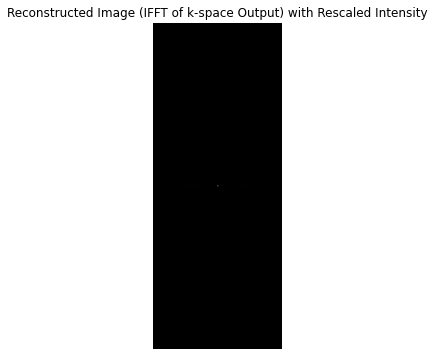

In [96]:
import torch
import torch.fft
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters and device setup
global_max_channels = 76        
timesteps = 1000
schedule = "cosine"
beta_start = 1e-4
beta_end = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume UNet and DDIM classes have been defined/imported appropriately.
# Instantiate the model with the same configuration as during training.
unet = UNet(
    in_channels=global_max_channels,    # should match the global_max_channels used in training
    out_channels=global_max_channels,
    features=[64, 128, 256],
)
ddim = DDIM(
    unet=unet,
    timesteps=timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    schedule=schedule,
    device=device
)

# Load the saved state dictionary
state_dict = torch.load("models/3_model.pt", map_location=device)
ddim.load_state_dict(state_dict)
ddim.to(device)
ddim.eval()

# --- Load a sample input ---
# shape [kx, ky, 2, coil]
sample = torch.load("mri-2/fs_0078_1_5T_slice0_phase12.pt", map_location=device)
print("Original sample shape:", sample.shape)  # e.g. [kx, ky, 2, coil]

# Permute from [kx, ky, 2, coil] to [2, coil, kx, ky]
sample = sample.permute(2, 3, 0, 1)
print("After permute:", sample.shape)  # Expected: [2, coil, kx, ky]

# Flatten the first two dimensions to get [C, kx, ky] with C = 2*coil.
sample = sample.reshape(-1, sample.shape[-2], sample.shape[-1])
print("After flattening channels:", sample.shape)  # e.g. [68, kx, ky]

# Pad (or crop) the channel dimension to match global_max_channels.
if sample.shape[0] < global_max_channels:
    pad_channels = global_max_channels - sample.shape[0]
    sample = F.pad(sample, (0, 0, 0, 0, 0, pad_channels))
    print("After padding, sample shape:", sample.shape)
elif sample.shape[0] > global_max_channels:
    sample = sample[:global_max_channels, :, :]
    print("After cropping, sample shape:", sample.shape)

# Add a batch dimension: now [1, C, H, W]
sample = sample.unsqueeze(0).to(device)

# --- Run the model ---
with torch.no_grad():
    t = torch.randint(0, timesteps, (sample.size(0),), device=device).long()
    kspace_output = ddim(sample, t=t, cond=None)
    # kspace_output should have shape [B, global_max_channels, H, W]
print("k-space output shape:", kspace_output.shape)

# --- Convert k-space output to image domain ---
B, C, H, W = kspace_output.shape
if C % 2 != 0:
    raise ValueError("Expected an even number of channels (coil*2).")
num_coils = C // 2

# Reshape to separate coil and complex dimensions: [B, num_coils, 2, H, W]
kspace_reshaped = kspace_output.view(B, num_coils, 2, H, W)
# Convert to a complex tensor: first channel is real, second is imaginary.
kspace_complex = torch.complex(kspace_reshaped[:, :, 0, :, :],
                                kspace_reshaped[:, :, 1, :, :])
# kspace_complex now has shape: [B, num_coils, H, W]

# Optionally apply ifftshift to center k-space
if True:
    kspace_complex = torch.fft.ifftshift(kspace_complex, dim=(-2, -1))

# Perform a 2D inverse FFT (with orthogonal normalization)
image_coils = torch.fft.ifft2(kspace_complex, norm='ortho')

# Optionally apply fftshift to recenter the image
if True:
    image_coils = torch.fft.fftshift(image_coils, dim=(-2, -1))

# Compute the magnitude for each coil image
coil_magnitudes = torch.abs(image_coils)

# Combine coil images using the Sum-Of-Squares (SOS) method: result [B, H, W]
reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))

# --- Rescale intensity via min–max normalization ---
img_min = reconstructed_image.min()
img_max = reconstructed_image.max()
reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)

# For visualization, take the first image in the batch
img_to_show = reconstructed_image[0].cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(img_to_show, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output) with Rescaled Intensity")
plt.axis("off")
plt.show()
